<a href="https://colab.research.google.com/github/GiorgiaVitanza/DataScience/blob/master/Homework8.3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving used_cars.csv to used_cars.csv


In [28]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.decomposition import PCA

# For modeling
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For Feature Importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import shap

# For pipeline creation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

In [41]:
df = pd.read_csv('used_cars.csv')
# Extract numeric part from 'milage' and convert to float
df['milage'] = df['milage'].str.replace(',', '').str.extract('(\d+)').astype(float)
# Remove commas and dollar signs before converting into int
df['price'] = df['price'].str.replace(',', '').str.replace('$', '').astype(int)

# Feature crossing (combining categorical features)

df['brand_model'] = df['brand'] + '_' + df['model']
df['fuel_type_engine_transmission'] = df['fuel_type'] + '_' + df['engine'] + '_' + df['transmission']
df['ext_col_int_col'] = df['ext_col'] + '_' + df['int_col']
df['accident_clean_title'] = df['accident'] + '_' + df['clean_title']
df.drop(['brand', 'model', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'], axis=1, inplace=True)

In [42]:
# Define feature types
numeric_features = ['milage', 'model_year']
categorical_features = ['brand_model', 'fuel_type_engine_transmission',	'ext_col_int_col',	'accident_clean_title']

# Define X and y
X = df.drop('price', axis=1)
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Create transformers for each feature type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with a Linear Regression model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [44]:
# Train the model with the pipeline
full_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = full_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

Mean Squared Error: 19576291165.03
Root Mean Squared Error: 139915.30
R-squared Score: 0.0422


                                                Feature     Importance
3095                                cat__int_col_Brandy  357924.700808
2847                            cat__ext_col_China Blue  249850.331249
308                       cat__model_Aventador SVJ Base  245232.179072
47                               cat__brand_Rolls-Royce  239950.665686
1936  cat__engine_208.0HP 2.0L 4 Cylinder Engine Gas...  190707.517434
...                                                 ...            ...
2724                  cat__engine_Dual Motor - Standard      28.780815
2675       cat__engine_6.7L I6 24V DDI OHV Turbo Diesel      23.231789
252                  cat__model_AMG GLE 43 Coupe 4MATIC      14.013039
1596                            cat__model_X3 xDrive30i       8.946654
3205                               cat__clean_title_Yes       0.000000

[3206 rows x 2 columns]


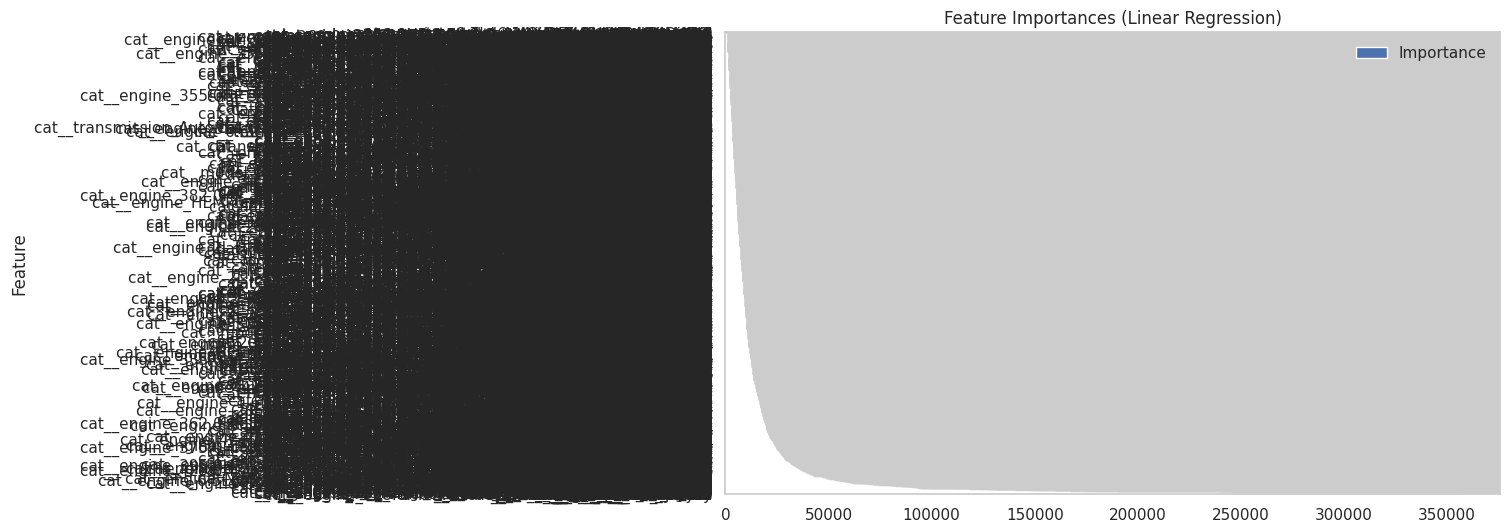

In [37]:
feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = full_pipeline.named_steps['regressor'].coef_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})

# Sort by importance (descending order)
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importances)
# Or, you can plot it:
feature_importances.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Feature Importances (Linear Regression)')
plt.show()




In [51]:
# 2. Feature selection using Random Forest importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
X_transformed = preprocessor.fit_transform(X, y)  # Transform X using the preprocessor
rf.fit(X_transformed, y)

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance based on Random Forest:")
print(rf_importances)



Feature importance based on Random Forest:
                                                Feature    Importance
0                                           num__milage  1.948015e-01
1266        cat__brand_model_Maserati_Quattroporte Base  1.203196e-01
3635  cat__fuel_type_engine_transmission_Gasoline_8....  1.078227e-01
3594  cat__fuel_type_engine_transmission_Gasoline_60...  6.257742e-02
344    cat__brand_model_Bugatti_Veyron 16.4 Grand Sport  5.569956e-02
...                                                 ...           ...
1401  cat__brand_model_Mercedes-Benz_GLA-Class GLA 2...  1.328027e-09
1187                  cat__brand_model_Lexus_RX 300 4WD  1.080820e-09
8                     cat__brand_model_Acura_Integra LS  5.107164e-10
1784              cat__brand_model_Toyota_Prius v Three  5.034282e-10
796              cat__brand_model_GMC_Yukon XL 1500 SLT  4.803301e-10

[4351 rows x 2 columns]

Selected features: []
Number of selected features: 0


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


In [52]:
# Select features based on importance threshold
selector = SelectFromModel(rf, threshold=0.1)  # Select features with importance > 0.1
X_rf_selected = selector.fit_transform(X_transformed, y)
# Get selected feature names from the preprocessor's output
selected_feature_indices = selector.get_support()
selected_features_rf = preprocessor.get_feature_names_out()[selected_feature_indices] # Use transformed feature names

print(f"\nSelected features: {selected_features_rf.tolist()}")
print(f"Number of selected features: {len(selected_features_rf)}")


Selected features: ['num__milage', 'cat__brand_model_Maserati_Quattroporte Base', 'cat__fuel_type_engine_transmission_Gasoline_8.0L W16 64V GDI DOHC Twin Turbo_7-Speed Automatic with Auto-Shift']
Number of selected features: 3


In [56]:
df.head()

,model_year,milage,fuel_type,price,brand_model,fuel_type_engine_transmission,ext_col_int_col,accident_clean_title
0,2013,51000.0,E85 Flex Fuel,10300,Ford_Utility Police Interceptor Base,E85 Flex Fuel_300.0HP 3.7L V6 Cylinder Engine ...,Black_Black,At least 1 accident or damage reported_Yes
1,2021,34742.0,Gasoline,38005,Hyundai_Palisade SEL,Gasoline_3.8L V6 24V GDI DOHC_8-Speed Automatic,Moonlight Cloud_Gray,At least 1 accident or damage reported_Yes
2,2022,22372.0,Gasoline,54598,Lexus_RX 350 RX 350,Gasoline_3.5 Liter DOHC_Automatic,Blue_Black,NaN
3,2015,88900.0,Hybrid,15500,INFINITI_Q50 Hybrid Sport,Hybrid_354.0HP 3.5L V6 Cylinder Engine Gas/Ele...,Black_Black,None reported_Yes
4,2021,9835.0,Gasoline,34999,Audi_Q3 45 S line Premium Plus,Gasoline_2.0L I4 16V GDI DOHC Turbo_8-Speed Au...,Glacier White Metallic_Black,NaN


In [62]:
# Define feature types
numeric_features = ['milage']
categorical_features = ['brand_model', 'fuel_type_engine_transmission']

# Define X and y
X = df.drop('price', axis=1)
y = df['price']

In [63]:
# Create transformers for each feature type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with a Linear Regression model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [64]:
# Train the model with the pipeline
full_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = full_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

Mean Squared Error: 19472191405.23
Root Mean Squared Error: 139542.79
R-squared Score: 0.0473
